# Summary slides

## Motivation of the study

### Summary

- Literature either increases B fields or particle size to increase force on the particle. Either of these are adjusted during a measurement. \
    $\rightarrow$ Estimated average viscoelasticy and hereogenity are readily biased \
    $\Rightarrow$ In the work the force acting on the bead is adjusted based on the theoretically computed field during measurement
- Theoretical model rarely apply directly to real world devices \
    $\rightarrow$ Incorrect adjustment \
    $\Rightarrow$ Use physics-informed machine learning taught with calibration data to tune the adjustment values 
- Classical microrheological models describe materials with springs and dash-pots \
    $\rightarrow$ Models have bad explainability and often dont provide frequency dependent response  \
    $\Rightarrow$ Use eqaution for generalized response


Hydrogels built from biologically relevant sources are widely used as $\text{in vitro}$ 3D models, also refered as 3D cell culture matrices. Traditionally, viscoelastic properties are measured with rheometer or using different microrheological. Rheological tools perfrom well for material science purposes providing macroscale mechanical response of the sample. However, biological applications require microscale viscoelastic values of the sample and their spatial variation. The cells themselves are microscale objects and hence response structural and viscoelastic clues in microscale. Viscoelastic clues have been shown to direct important cell function, but more importantly in cell malfunctions as in cancer progression. 

Particularly, microrheology has proven an effective tool to measure viscoelastics in microscale. Microrheology can measure inside the sample and is not limited to surface or surface interface of the sample as AFM and optical tweezers. The method is compatible with live-cell experiments and is not invasive for the sample. Furthermore, large forces up to tens of nanonewtons can be focused on the magnetic particles enabling measurements of samples from $\sim$ 10-10kPa of youngs modulus. For example, the range covers the whole range of breast cancer viscoelasticity from its benign phase to malignant invasive phase. 

Nevertheless, such forces are not straightforward to produce at highly controlled manner. Either magnetic field, the gradient of magnetic field or the size of the beads can be increased, or the material of the probes can be varied. The spatial decay of magnetic field and its gradient have a non-linear nature. This results spatially differing forces during a measurement. This reduces significantly methods' thought-put and limits maximal strains during a measurement which are not often compensated during a measurement. Furthermore, increasing or decreasing particle size from instance from 10 $\mu$ m to 100 $\mu$ m likely changes the measured microenvironment. The change of the particle material might change interactions with the surrounding matrix. The mentioned draw backs are not distunguishable during the measurements but increase the diviation of the measured data. In worst case, they break the assumptions made in calculations. Wide multisource deviation can shift average viscoelastic values, and they complicate heterogenity mapping due to increased noise-to-signal ratio.

To address these problems, current dependent magnetic fields and gradients can be modeled. This enables adjustment of the force acting on a particle during the measurement allowing the computation of exact viscoelasticity and its spatial variation. The constancy assumption of magnetic field and its gradient no longer limits the maximal strain in the system. Often, no human made system perfectly corresponds to theory or the theories are not absolute. Therefore, physics-informed machine learning is utilized to tune the theoretical model to correspond the calibration data set.


## What was done

Shortly, projects consist of x phases. First, make a new hardware codes to drive microrheometer with sufficient speed and accesibilty to include models for force adjustment. Secondly, redesign table, sample holder, and coil holder to decouple sample manipulation from coils. In additionally, coil was placed in angle for experimental practicality. Lastly, the analysis pipe is coded.

1) Hardware
    - Main thread: 
        - Qthreading and management
        - interface
        - Signaling with Qt slot and signal functions
        - Video saving (ffmpeg)
    - Sub-thread: Camera (pyPylon)
        - Acquire images
        - tracking
    - Sub-thread: Ni-DAQ unit (niDaqmx)
        - sampling coil current and magnetic field sensor
        - Output current contol via PID (B and I feedback separate)
    - Sub-thread: Model 
        - Aquire coordinates from the tracker, locate the bead, and calculate adjustment value
2) Coil design
    -Coil fixed on table in an angle with hall-sensor pocket. Sample holder moves with manual manipulator.
    <img src = "img.png"  width="500" height="340">
3) Analysis Pipe
        

# OneCoil project Notebook

## Theory

Force experienced by a magnetic bead in an external non-homogenous B overlayed with gradient current $\nabla B$. Here, we focus on 2D problem since microscope FoV limits observations to 2D projections. The derivation is mostly based on the book Microrheology by M. Furst and T. Squires.

A paramagnetic sphere in non-homogenous magnetic field experiences a force:

$
\begin{align}
F_{bead} &= V \cdot M(B) \cdot \nabla B(x,y)
\end{align}
$

M - Magnetization of the bead (A/m), V - volume of the bead ($m^3$), and $\nabla$ B - magnetic field gradient. 

### Volume, V

Volume of the particle is determined acquiring a z-stack over the particler volume and determining the largest cross-section of the particle using laplacian variance (<a href="https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv//"> article</a>)

### Magnetic field, B

B depends on directly on i linearly or non-linearly depending on the core properties and the magnitude of the current. Assuming constant core permeability gives linear dependence between B and i$_input$ whereas empirically measured B-H -curve based core permeability suggests non-linear dependence which saturates at higher current magnitudes.

B was simulated using Comsol and Gaussian current loop technique [reference]. Simulations were performed using Comsol time-dependent moduli (simulation attached) and a 0.5 A step wave. $\nabla B_x$ and $\nabla B_y$ were calculated from the obtained $B$. The spatial density of the simulation was 0.05mm ( $\partial x = \partial y = 5 \cdot 10^{-5}$) and geometry was defined assuming rotational symmetry as  (<a href="https://pubs.acs.org/doi/full/10.1021/acsami.5b06937"> Pokki et al 2015</a>).  

$
\begin{align}
|B| &=  \sqrt{ B_x^2 + B_y^2} \\
\nabla B_x &= \frac{ \partial |B|}{\partial x} \\
\nabla B_y &= \frac{ \partial |B|}{\partial y} \\
\end{align}
$

M(B) can be derived from magnetization measurements which give magnetic moment ($m$) as a function of magnetic field intensity ($H$). The collected experimental data can be fitted using Fröhlich-Kennelly function. 

$
\begin{align}
B = (\frac{1}{X_0} + \frac{|H|}{M_\textrm{sat}})^{-1}
\end{align}
$

where $X_0$ is magnetic susceptilibity and $M_\textrm{sat}$ is saturation magnetization

Duet to the magnetic moment ($m$) measurement methods, volumetric magnetization was calculated via mass magnetization spesifying individual value for each particle using density, $\rho$.

$
\begin{align}
M_{\text{mass}} &= \frac{m}{mass} \\
M_{\text{volumetric}} &= M_{\text{mass}} \cdot \rho
\end{align}
$

### Empirical Force

On the other hand, force can also be determined empirically using Stokes law

$
\begin{align}
F_{\text{stokes}} &= 6 \pi R \eta v \\
\end{align}
$

where $R$ is bead radius, $\eta$ viscosity, and $v$ is bead velocity.



### Simulation 

Similar assumtions as in Stokes-Einstein relation (<a href="https://www.annualreviews.org/doi/pdf/10.1146/annurev-fluid-121108-145608"> super ref</a>) were considered to be valid. Note: It is expected that some of the assumptions breakdown as discussed in the paper. However, these does not make the calculations invalid, the interpretation just changes and the results cannot be directly compared for instance with macroscale data.

A displacement model to estimate particle trajectories and total forces acting on particles were done assuming Eq.1 and no resistance from the medium

k - number of timestep

dt - length of timestep

$\rho$ - density

$ s_{k, \textrm{bead}} $ - bead position

$ v_{k, \textrm{bead}} $ - bead velocity

$
\begin{align}
f_{\textrm{tot}} &= f_{\textrm{bead}}  \\
v_{k, \text{bead}} &= \frac{f_{\textrm{bead}}}{m} \cdot dt \\
s_{k, \textrm{bead}}  &= s_{k-1, \text{bead}} + v_{k, \text{bead}} \cdot dt  \\
\end{align}
$

## Analysis

Mechanocal pareameters were derived from simulated and experimental displacement data using 1) micromechanical models and 2) generalized response (<a href="https://journals.aps.org/pre/pdf/10.1103/PhysRevE.80.012501"> derivation in Evans et al </a>). Without B adjustment moving bead do not experience constant magnetic gradient since nonhomogenous B. However, if the displacements are small, constant force is a valid assumption. 

One of the aims of this work is to compare how much this assumptions effects on final results. 


## Micromechanical models

#### Creep:

kelvin-Voigt model and burger model:

$
\begin{align}
\epsilon_{\text{Kelvin-Voigt}} (t) &= \frac{1}{E}*(1-e^{\frac{-E t}{n}}) \\
\epsilon_{\text{Burger's}} (t) &= \sigma \left( \frac{1}{E_1} + \frac{t}{n_1} + \frac{1}{E_2} (1 - e^{ \frac{-E_2 t}{n_2}}) \right)
\end{align}
$

#### Relaxation:

maxwell model and burger model:

$
\begin{align}
\epsilon_{\text{Kelvin-Voigt}} (t) &= E e^{ \frac{- E t}{n}} \\
\epsilon_{\text{Burger's}} (t) &= \frac{t_c}{n_1} (1 - e^{- \frac{t-t_c}{n_2/E_2}} + \frac{1}{E_1} e^{- \frac{t-t_c}{n_2/E_2}})
\end{align}
$

## Generalized response

$
\begin{align}
G'(\omega) + i G''(\omega) &= \frac{i \omega}{ i \omega J (0) + \dot{J(0)} + \mathscr{F}[J_2](\omega)} \\
\frac{i \omega}{G^*(\omega)} &= i \omega J(0) + (1-e^{-i \omega t_1}) \frac{J_1 - J(0)}{t_1} + \frac{e^{-i \omega t_N}}{\eta} + \sum_{k=2}^{N} \left( \frac{J_k - J_{k-1}}{t_k - t_{k-1}} \right) (e^{-i \omega t_{k-1}} - e^{-i \omega t_k}) \\
J(t) &= \frac{ \gamma }{ \sigma } = \frac{ \Delta x /(2r) }{ F_\textrm{bead}/(\pi r^2) } 
\end{align}
$

$J(0)$ and $\eta$ can also be derived from the fit

$
\begin{align}
J(t) &= \frac{t}{\eta} + a + b \cdot tanh(c+d \cdot ln(t)+e \cdot ln^2(t) + f \cdot ln^3(t) \\
\end{align}
$




## ToDo list

- [x] Improve code to reach 100Hz sampling and 40fps visualization with tracking and model
- [x] Tune I Feedback
- [x] Tune B Feedback
- [ ] Coil angle compensation
- [ ] 10µm bead magnetization curve
- [ ] 10µm bead density
- [ ] Estimated force is $10^2$ larger than measured
- [ ] Field correction algorythm
- [ ] trajectory estimation
- [ ] plasticity fit

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os 

import _pickle as cPickle
from glob import glob

import json

import scipy
from scipy.optimize import curve_fit

import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


# Setup Characterization

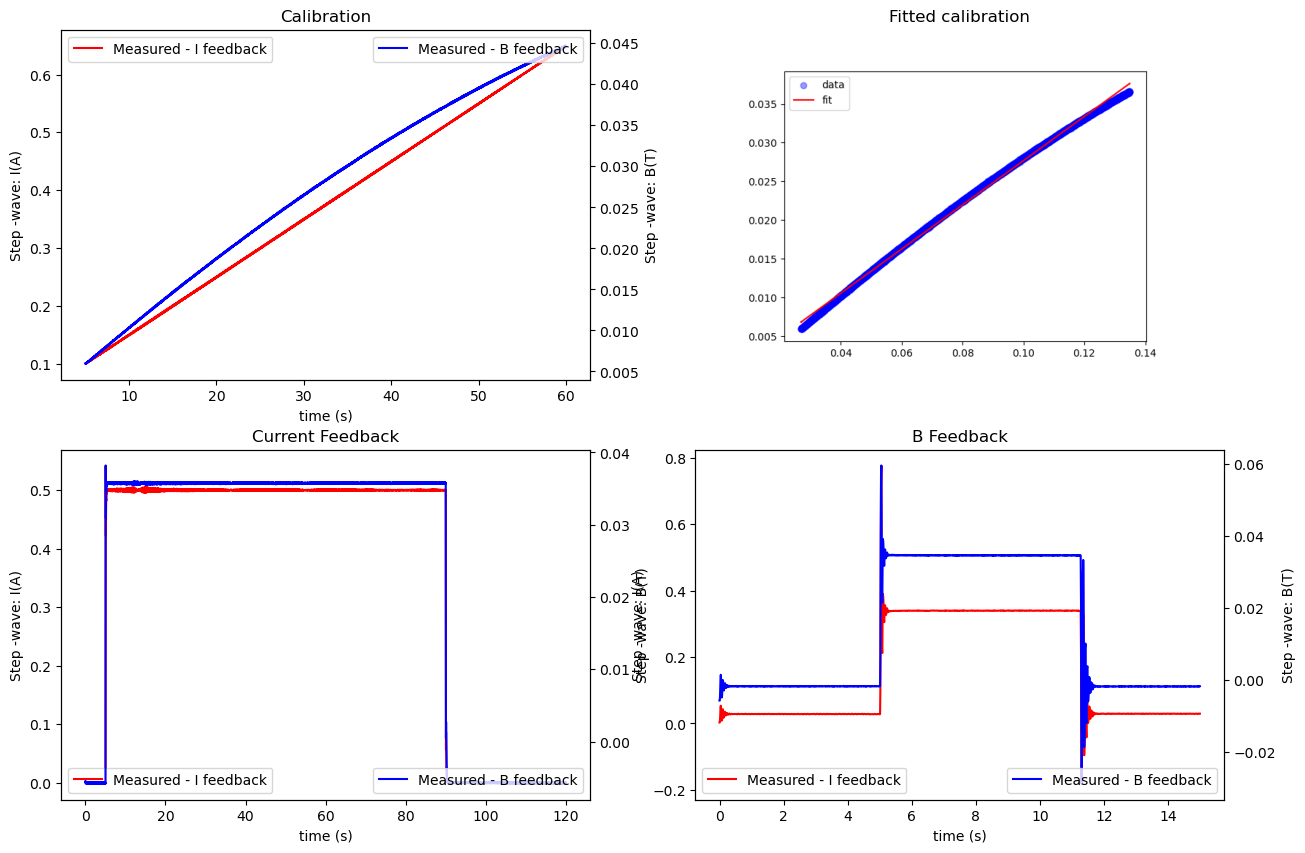

In [100]:
fig, ax  = plt.subplots(2, 2, figsize = (15,10))

#Load calibration
path_calib = "E:/demoData/calib/calib_2024-02-01.npy"
df_calib = pd.DataFrame(np.load(path_calib).T, columns = ['index','aim','measured','Mg', 'scaler'])

start = 500
end = 6000

ax[0,0].set_title("Calibration")
ax1 = ax[0,0].twinx()

ax[0,0].plot(df_calib["index"][start:end],df_calib["measured"][start:end], color = "red", label = "Measured - I feedback")
ax1.plot(df_calib["index"][start:end],df_calib["Mg"][start:end], color = "blue", label = "Measured - B feedback")

ax[0,0].set_ylabel("Step -wave: I(A)")
ax[0,0].set_xlabel("time (s)")
ax1.set_ylabel("Step -wave: B(T)")

ax[0,0].legend(loc = "upper left")
ax1.legend(loc = "upper right")

#Calibration fit
ax[0,1].set_title("Fitted calibration")
img = cv2.imread("E:/demoData/calib/calib_2024-02-01.png")
ax[0,1].imshow(img)
ax[0,1].axis("off")

#Load current feedback
path_current = "E:/demoData/current_1/driver_2024-02-01.npy"
df_current = pd.DataFrame(np.load(path_current).T, columns = ['index','aim','measured','Mg', 'scaler'])

ax[1,0].set_title("Current Feedback")
ax2 = ax[1,0].twinx()

ax[1,0].plot(df_current["index"],df_current["measured"], color = "red", label = "Measured - I feedback")
ax2.plot(df_current["index"],df_current["Mg"], color = "blue", label = "Measured - B feedback")

ax[1,0].set_ylabel("Step -wave: I(A)")
ax[1,0].set_xlabel("time (s)")
ax2.set_ylabel("Step -wave: B(T)")

ax[1,0].legend(loc = "lower left")
ax2.legend(loc = "lower right")

#Load current feedback
path_B = "E:/demoData/B_3/driver_2024-02-01.npy"
df_B = pd.DataFrame(np.load(path_B).T, columns = ['index','aim','measured','Mg', 'scaler'])

ax[1,1].set_title("B Feedback")
ax3 = ax[1,1].twinx()

ax[1,1].plot(df_B["index"],df_B["measured"], color = "red", label = "Measured - I feedback")
ax3.plot(df_B["index"],df_B["Mg"], color = "blue", label = "Measured - B feedback")

ax[1,1].set_ylabel("Step -wave: I(A)")
ax[1,1].set_xlabel("time (s)")
ax3.set_ylabel("Step -wave: B(T)")

ax[1,1].legend(loc = "lower left")
ax3.legend(loc = "lower right")



# Data processing 

### Donwload data and process data

In [4]:
def calc_force(data):

    radius = 5.5e-6
    T_0 = 25
    r_T_0 = 0.971e3
    v = 30000e-6
    volume = np.pi*radius**2

    # our experiments
    T = 23
    a = 9.2e-4
    b = 4.5e-7
    r = r_T_0/(1+a*(T-T_0)+b*(T-T_0)**2)
    nn = v*r

    v_fit = np.mean(np.abs(data))
    F_fit = 6*np.pi*nn*radius*v_fit

    return F_fit

def func(x, a, b):
    return a*np.tanh(x*b)

def func_Fk(x, x_0, H_sat):
    return x/(1/x_0 + np.abs(x)/H_sat)

def G(omega, J0, n, sum, t1, J1, t_last):
    j=1j
    return j*omega*J0 + (1-np.exp(-j*omega*t1))*(J1-J0)/t1 + np.exp(-j*omega*t_last)/n + sum

def J_t(t, eta, a, b, c, d, e, f):
    return (t/eta) + a + b*np.tanh(c + d*np.log(t) + e*np.log(t)**2 + f*np.log(t)**3)

def kelvin(t,tau,D):
    return D*(1-np.exp(-t/tau))

def maxwell(t, D, tau):
    return D*(1+t/tau)

def maxwell_rel(t, E, tau ):
    return E*np.exp(-t/tau) 

def burger_model(x, E_1, E_2, n_1, n_2):
    return 1/E_1 + x/n_1 + 1/E_2*(1-np.exp(-x*E_1/n_2))

def burger_rel(x, E_1, E_2, n_1, n_2):
    t_c = 1
    return t_c/n_1*(1- np.exp(-(x-t_c)/(n_2/E_2))) + (1/E_1)*np.exp(-(x-t_c)/(n_2/E_2))

def Weibull_creep(x, e_i, e_c, beta, tau):
    return e_i + e_c*(1-np.exp(-(x/tau)**beta))

def Weibull_rel(x, e_r, e_f, beta, tau):
    return e_f + e_r*(np.exp(-(x/tau)**beta))


In [5]:
root = "E:/demoData"

#Configs
ni_rate = 100 #NI acquisition rate
camera_rate = 40 #Camera acquisition rate
rate_rate = ni_rate/camera_rate #Ratio between acquisitions

m = 3.5/(10*0.3*2.6) #Pixel size

#Find starting and stopping index
start = int(500/rate_rate)
end = int(1150/rate_rate)


radius = 5.5e-6 #Bead size m
rho = 1.3 * 1000 #Bead density kg/m^3

mu_0 = 4*np.pi*1e-7 #permeability

height = 1544*m*1e-6 #height of FoV in µm
width = 2064*m*1e-6 #width of FoV in µm

#Parameters to crop simulation
start_w =  0.0035 - width 
end_w = 0.0035
start_h = 0.003 - height/2
end_h = 0.003 + height/2


#Download frame for visualization glitter
path_vid = glob(os.path.join(root,"track_5/*.mp4"))
cap = cv2.VideoCapture(path_vid[0])
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        #frame = cv2.flip(frame,0)
        break


### Magnetization data

In [55]:
paths = glob(os.path.join(root,"resource/*.dat"))


for count,i in enumerate(paths):
    ending = i.split("\\")[-1]
    parts = ending.split("_")
    day = parts[0]
    weight = float(parts[2][:-6])*1e-8 #*0.0275

    df_sub = pd.read_csv(i, sep= ",", skiprows = np.arange(0,31)).iloc[1:, :].dropna(how='all', axis = "columns")
    df_sub["sample"] = count
    df_sub["weight"] = weight

    #Oe  1/(4pi)*10^3 A/m
    df_sub["H"] = df_sub["Magnetic Field (Oe)"] * 1/(4*np.pi)*1e3
    #= 1 emu 10−3 A·m2
    df_sub["moment"] = df_sub["Moment (emu)"]*1e-3

    start_sat = np.where(df_sub["H"][:125].values>600e3)[0][0]
    end_sat = np.argmax(df_sub["H"][:125].values)

    k = np.polyfit(df_sub["H"][start_sat:end_sat].values,df_sub["moment"][start_sat:end_sat].values-df_sub["moment"][start_sat:end_sat].values[0],deg = 1, cov = False)
    offset = k[0]*df_sub["H"]

    df_sub["moment"] = df_sub["moment"] - offset
    df_sub["M_mass"] = df_sub["moment"]/(weight)

    if count == 0:
        df_bead = df_sub
    else:
        df_bead = pd.concat((df_bead,df_sub))

df_bead["H_round"] = np.round(df_bead["H"].values, -5)
fd_mean = df_bead.groupby(["H_round"]).mean().reset_index()
mask = fd_mean["H"].values >= 0
xdata = np.linspace(0,800000,1000)
popt, pcov = curve_fit(func_Fk, fd_mean["H_round"][mask], fd_mean["M_mass"][mask], method = "dogbox", bounds = [[0,0],[10,np.inf]])
ydata = func_Fk(xdata, *popt)

M_mag = ydata*rho
B_mag = xdata*mu_0

### Download simulation

In [57]:

df_sim = pd.read_csv(os.path.join(root, "resource/One_coil.csv"), sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])
df_sim["Bx"] = scipy.ndimage.gaussian_filter1d(df_sim["Bx"].values,5) 
df_sim["By"] = scipy.ndimage.gaussian_filter1d(df_sim["By"].values,5)
df_sim["x"] = np.round(df_sim["x"], 5) #- (0.0035 - width)
df_sim["y"] = np.round(df_sim["y"], 5) #- (0.003 - height/2)

df_sim["B"] = np.sqrt((df_sim["Bx"].values)**2 +  df_sim["By"].values**2)
B = df_sim["B"].values

map_x = df_sim["x"].values
map_y = df_sim["y"].values


xx__ = np.linspace(start_w,end_w, frame.shape[1]) #- (0.0035 - width)
yy__ = np.linspace(start_h,end_h, frame.shape[0]) #- (0.003 - height/2)

test_frame = 255-cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
phase = 5

y_unique = np.unique(map_y) 
x_unique = np.unique(map_x) 
y_u = len(np.unique(map_y))
x_u = len(np.unique(map_x))

y_coord = np.concatenate((x_unique, x_unique+np.max(x_unique)))
x_coord = y_unique
B = B.reshape((y_u, x_u))

BB = np.vstack((B.T[::-1,:], B.T))
filtered = scipy.ndimage.gaussian_filter(BB, 5)

dBy = scipy.ndimage.gaussian_filter(np.gradient(filtered, np.diff(df_sim["x"]).mean(), axis  = 1),5)#*np.sin(angle)
dBx = -scipy.ndimage.gaussian_filter(np.gradient(filtered, np.diff(df_sim["x"]).mean(), axis  = 0),5)#*np.cos(angle)

X1, Y1 = np.meshgrid(x_coord, y_coord)

# Download and parse track data

#### Multiple files

In [58]:
path_multi_track = glob(os.path.join(root,"track_*/*.json"))

ref_flag = True
mg_flag = True

ref_label = 0
mg_label = 0 

for current_path in path_multi_track:

    with open(current_path, "rb") as input_file:
        file_dict = json.load(input_file)

    for i in file_dict.keys():
        parts = i.split("_")
        if parts[0] == "ref":
            if ref_flag:
                temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end][start:end].reset_index()
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
                df_ref = temp_df
                df_ref["label"] = ref_label
                ref_label += 1
                ref_flag = False
            else:
                temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
                temp_df["label"] = ref_label
                ref_label += 1
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
                df_ref = pd.concat((df_ref,temp_df))
            df_ref["type"] = "ref"
            #df_ref["label"] = parts[1]
        else:
            if mg_flag:
                temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
                df_mg = temp_df
                df_mg["label"] = mg_label
                mg_label += 1
                mg_flag = False
            else:
                temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
                temp_df["label"] = mg_label
                mg_label += 1
                temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
                temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
                df_mg = pd.concat((df_mg,temp_df))
            
            df_mg["type"] = "mg"
                #df_mg["label"] = parts[1]
            
df_mg["y_scaled"] = df_mg["y"]*1e-6*m + start_h
df_mg["x_scaled"] = df_mg["x"]*1e-6*m + start_w

### One File

In [5]:
path_multi_track = glob(os.path.join(root,"track_5/*.json"))
with open(path_multi_track[0], "rb") as input_file:
    file_dict = json.load(input_file)

for i in file_dict.keys():
    parts = i.split("_")
    if parts[0] == "ref":
        if parts[1] == "0":
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end][start:end].reset_index()
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_ref = temp_df
            df_ref["label"] = parts[1]
        else:
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
            temp_df["label"] = parts[1]
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_ref = pd.concat((df_ref,temp_df))
        df_ref["type"] = "ref"
        #df_ref["label"] = parts[1]
    else:
        if parts[1] == "0":
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_mg = temp_df
            df_mg["label"] = parts[1]
        else:
            temp_df = pd.DataFrame.from_dict(file_dict[i])[start:end].reset_index()
            temp_df["label"] = parts[1]
            temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"],1)
            temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"],1)
            df_mg = pd.concat((df_mg,temp_df))
        
        df_mg["type"] = "mg"
            #df_mg["label"] = parts[1]
        
df_mg["y_scaled"] = df_mg["y"]*1e-6*m + start_h
df_mg["x_scaled"] = df_mg["x"]*1e-6*m + start_w

### Visualize displacement and theoretical field

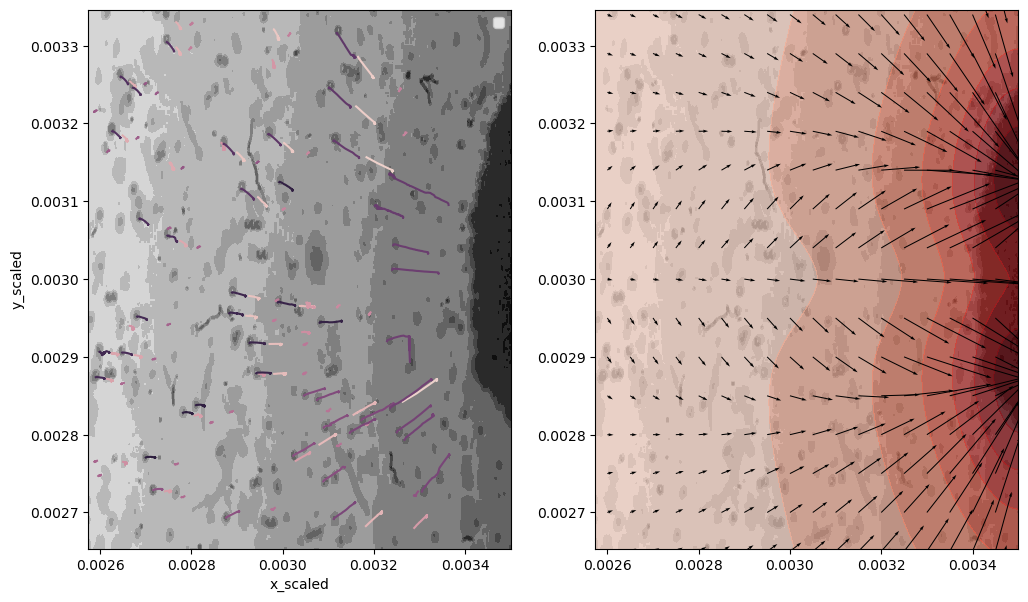

In [59]:
fig, ax  = plt.subplots(1, 2, figsize = (12,7))


ax[1].contourf(xx__, yy__, test_frame, alpha = 1, cmap="binary")
ax[1].contourf(x_coord, y_coord, filtered, alpha = 0.5, cmap = "Reds")
ax[1].quiver(X1[::phase, ::phase], Y1[::phase, ::phase], dBy[::phase,::phase], -dBx[::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]

ax[1].set_xlim([start_w,end_w])
ax[1].set_ylim([start_h,end_h])

ax[0].contourf(xx__, yy__, test_frame, alpha = 1, cmap="binary")
sns.lineplot(x = "x_scaled", y = "y_scaled", data = df_mg, hue = "label", ax = ax[0])
ax[0].legend([])

### Empirical and theoretical forces

In [70]:
df_col = pd.DataFrame()

for tags,i in df_mg.groupby(["label"]):

    timer = 0


    i["v"] = np.sqrt(np.gradient(i["x_scaled"]*m*1e-6)**2 + np.gradient(i["y_scaled"]*m*1e-6)**2)
    F = calc_force(i["v"].values) #Force from Stokes eq.
    i["F_stokes"] = F

    force_vector = np.zeros(len(i["x_scaled"].values))

    for x_pos, y_pos in zip(i["x_scaled"].values,i["y_scaled"].values):
                     
        x_idx = np.argmin(np.abs((x_coord-x_pos)))
        y_idx = np.argmin(np.abs((y_coord-y_pos)))

        B_current = BB[y_idx, x_idx]
        H_current = B_current/mu_0

        mu_idx = np.argmin(np.abs(xdata - H_current))
        mu_current = M_mag[mu_idx]

        F_field_x = -4/3*np.pi*(radius)**3*mu_current*dBx[y_idx,x_idx] #Estimate
        F_field_y = -4/3*np.pi*(radius)**3*mu_current*dBy[y_idx,x_idx] #Estimate

        force_vector[timer] =  np.sqrt((F_field_x)**2 + (F_field_y)**2)

        timer += 1

    i["force"] = force_vector
    
    if df_col.shape == 0:
        df_col = i
    else:
        df_col = pd.concat((df_col, i))
    count += 1

### Visualize degree of magnetization and spatially dependent empirical force and computed force

Text(0.5, 0, 'Force (N)')

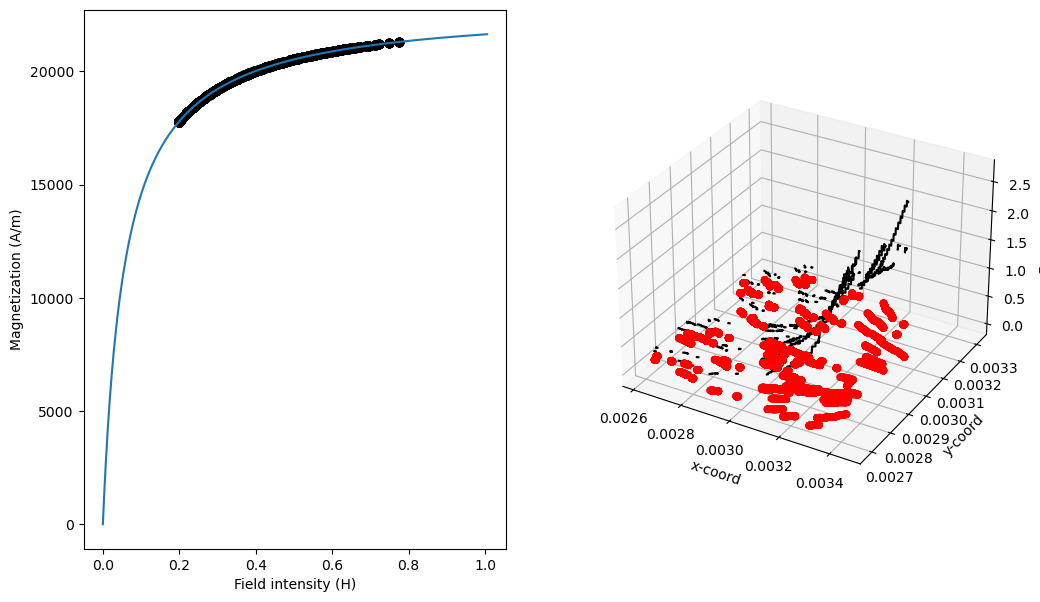

In [73]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(B_mag, M_mag)


for tags,i in df_col.groupby(["label"]):

    ax2.scatter(i["x_scaled"],i["y_scaled"], i["F_stokes"], color = "red")

    for x_pos, y_pos in zip(i["x_scaled"].values,i["y_scaled"].values):
                     
        x_idx = np.argmin(np.abs((x_coord-x_pos)))
        y_idx = np.argmin(np.abs((y_coord-y_pos)))

        B_current = BB[y_idx, x_idx]
        H_current = B_current/mu_0
        mu_idx = np.argmin(np.abs(xdata - H_current))

        ax1.scatter(B_mag[mu_idx], M_mag[mu_idx], color = "black")


    ax2.plot(i["x_scaled"].values,i["y_scaled"].values, i["force"], color = "black")
    

ax1.set_xlabel("Field intensity (H)")
ax1.set_ylabel("Magnetization (A/m)")

ax2.set_xlim([start_w,end_w])
ax2.set_ylim([start_h,end_h])

ax2.set_xlabel("x-coord")
ax2.set_ylabel("y-coord")
ax2.set_zlabel("Force (N)")


### Microrheological models

In [7]:
def kelvin(t,tau,D):
    return D*(1-np.exp(-t/tau))

def maxwell_creep(t, D, tau):
    return D*(1+t/tau)

def maxwell_rel(t, E, tau ):
    return E*np.exp(-t/tau) 

def burger_creep(x, E_1, E_2, n_1, n_2):
    return 1/E_1 + x/n_1 + 1/E_2*(1-np.exp(-x*E_1/n_2))

def burger_rel(x, E_1, E_2, n_1, n_2):
    t_c = 1
    return t_c/n_1*(1- np.exp(-(x-t_c)/(n_2/E_2))) + (1/E_1)*np.exp(-(x-t_c)/(n_2/E_2))

def Weibull_creep(x, e_i, e_c, beta, tau):
    return e_i + e_c*(1-np.exp(-(x/tau)**beta))

def Weibull_rel(x, e_f, e_r, beta, tau):
    return e_f + e_r*(np.exp(-(x/tau)**beta))

def fit_classicMicro(x, y, label, start, end, helper):

    #x -= x[0]
    #param = {}

    t_hat_creep = np.arange(x[start],x[end], 0.001)
    t_hat_rel = np.arange(x[end], x[helper], 0.001)

    x_creep = x[start:end] - x[start]
    x_rel = x[end:helper] - x[end]

    y_creep = y[start:end] - y[start]
    y_rel = y[end:helper] - y[start]

    xx = np.concatenate((x_creep, x_rel+x[end]-x[start]))
    yy = np.concatenate((y_creep, y_rel))

    if label == "Maxwell":
        p_creep, p_creep_e = curve_fit(maxwell_creep, x_creep, y_creep, method = "dogbox") 
        p_rel, p_rel_e = curve_fit(maxwell_rel, x_rel, y_rel, method = "dogbox")

        param = [p_creep, p_rel]

        ydata = np.concatenate((maxwell_creep(t_hat_creep,*p_creep), maxwell_rel(t_hat_rel-t_hat_rel[0],*p_rel)))
        xdata = np.concatenate((t_hat_creep, t_hat_rel))

    elif label == "Burger":
        p_creep, p_creep_e = curve_fit(burger_creep, x_creep, y_creep, method = "dogbox")
        p_rel, p_rel_e = curve_fit(burger_rel, x_rel, y_rel, method = "dogbox")

        param = [p_creep, p_rel]

        ydata = np.concatenate((burger_creep(t_hat_creep,*p_creep), burger_rel(t_hat_rel-t_hat_rel[0],*p_rel)))
        xdata = np.concatenate((t_hat_creep, t_hat_rel))

    elif label == "Weibull":
        p_creep, p_creep_e = curve_fit(Weibull_creep, x_creep, y_creep, method = "dogbox")
        p_rel, p_rel_e = curve_fit(Weibull_rel, x_rel, y_rel, method = "dogbox")

        param = [p_creep, p_rel]

        ydata = np.concatenate((Weibull_creep(t_hat_creep,*p_creep), Weibull_rel(t_hat_rel-t_hat_rel[0],*p_rel)))
        xdata = np.concatenate((t_hat_creep, t_hat_rel))

    ydata[0] = 0
    
    return xx, yy, xdata, ydata, param
    




#### First lets fit creep and recovery separately

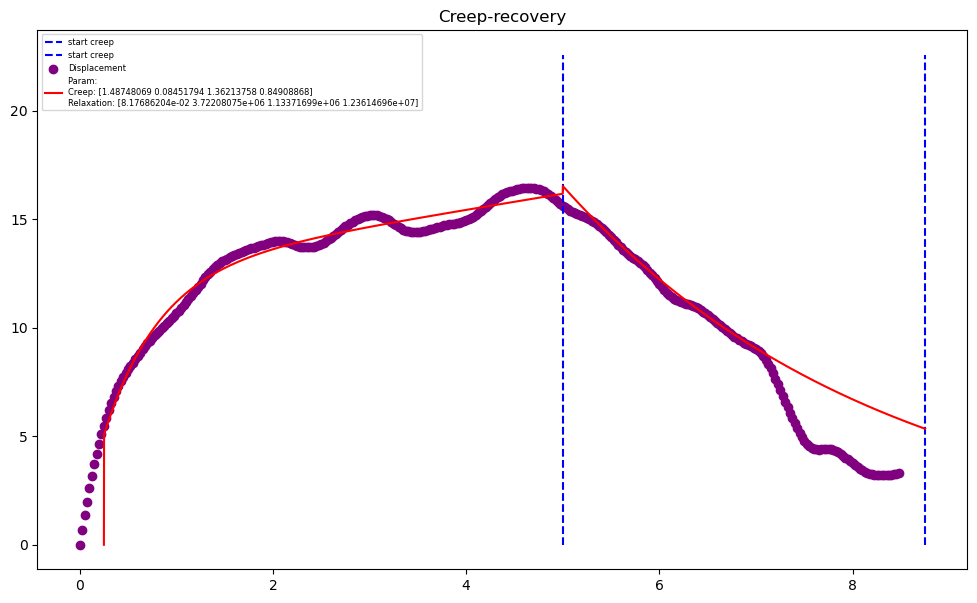

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,7))

path_track = os.path.join(root, "track_1/trackingData_2024-02-01.pickle")

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)
df_track = pd.DataFrame.from_dict(file_track)

start = 10
end = 200
helper = 350

df_track["time"] = df_track["t"]*1/40
df_track["x"] = scipy.signal.detrend(scipy.ndimage.gaussian_filter(df_track["x"],5))
df_track["y"] = scipy.signal.detrend(scipy.ndimage.gaussian_filter(df_track["y"],5))
df_track["x"] -= df_track["x"].min()
df_track["y"] -= df_track["y"].min()
df_track["r"] = np.sqrt(df_track["x"]**2 + df_track["y"]**2)
df_track["r"] = df_track["r"].max() - df_track["r"]

label_list = ["Maxwell", "Kelvin-Voigt", "Burger", "Weibull"]


ax.set_title("Creep-recovery")
#ax.plot(df_track["time"],df_track["x"], color = "red", label = "x-displacement")
#ax.plot(df_track["time"],df_track["y"], color = "black",label = "y-displacement")

ax.vlines(df_track["time"].values[end], df_track["r"].min(), df_track["r"].max(), color = "blue", label = "start creep", linestyle = "dashed")
ax.vlines(df_track["time"].values[helper], df_track["r"].min(), df_track["r"].max(), color = "blue", label = "start creep", linestyle = "dashed")

x = df_track["time"]
y = df_track["r"]

current_label = label_list[-2]
xx, yy, xdata, ydata, label = fit_classicMicro(x,y, current_label, start, end, helper)
ax.scatter(xx , yy, color = "purple", label = "Displacement")
ax.plot(xdata, ydata, label = "Param: \nCreep: {}\nRelaxation: {}".format(label[0], label[1]), color = "red")
ax.legend(loc = "upper left",fontsize = 6)

### Then fit at the same time

In [25]:
class burger():

    def __init__(self, t_c, epsilon, start, end, helper):
        self.epsilon_0 = epsilon

        self.t_hat_creep = None
        self.t_hat_rel = None

        self.t_c = t_c
        self.end = end
        self.start = start
        self.helper = helper

        
    def burger_creep(self, x, E_1, E_2, n_1, n_2):
        return 1/E_1 + x/n_1 + 1/E_2*(1-np.exp(-x*E_1/n_2))
        
    def burger_rel(self, x,E_1, E_2, n_1, n_2):
        return self.t_c/n_1*(1-np.exp(-(x-self.t_c)*(E_2/n_2))) + (self.epsilon_0-1/E_1)*np.exp(-(x-self.t_c)*(E_2/n_2))
    
    def combined(self, x_tot, E_1, E_2, n_1, n_2):
        # single data reference passed in, extract separate data


        extract1 = x_tot[:self.end-self.start] # first data
        extract2 = x_tot[self.end-self.start:] # second data

        result1 = self.burger_creep(extract1, E_1, E_2, n_1, n_2)
        result2 = self.burger_rel(extract2, E_1, E_2, n_1, n_2)

        return np.append(result1, result2)
    
    def fit(self, x, y):

        x_ = x[self.start:self.helper]-x[self.start]
        y_ = y[self.start:self.helper]-y[self.start]

        self.t_hat_creep = np.arange(x[start],x[end], 0.001) -x[self.start]
        self.t_hat_rel = np.arange(x[end], x[helper], 0.001) -x[self.start]

        p, pcov = curve_fit(self.combined, x_, y_, maxfev = 100000)

        yy_creep = self.burger_creep(self.t_hat_creep,*p)
        yy_rel = self.burger_rel(self.t_hat_rel,*p) 

        xx = np.concatenate((self.t_hat_creep, self.t_hat_rel))
        yy = np.concatenate((yy_creep, yy_rel))

        return xx, yy, p

Text(0, 0.5, ' $\\epsilon$ ($\\mu$m)')

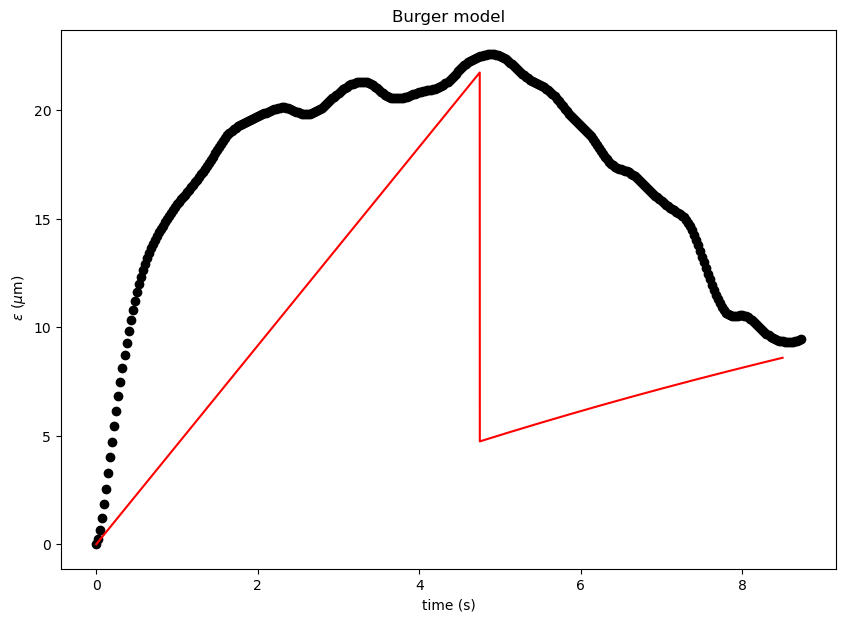

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,7))


model = burger(x[end]-x[start], np.mean(x[end-20:end]), start, end, helper)

# curve fit the combined data to the combined function
xx, yy, p = model.fit(x,y)
ax.plot(xx, yy, color = "red")
ax.scatter(x[:helper],y[:helper], color = "black")

ax.set_title("Burger model")
ax.set_xlabel("time (s)")
ax.set_ylabel(r" $\epsilon$ ($\mu$m)")

### General response

In [85]:
j = 1j

df_sub = df_col[df_col["label"] == 35]
r = np.sqrt(df_sub["x_scaled"]**2 + df_sub["y_scaled"]**2)
r = r-r[0]
t = np.linspace(1e-12,len(r)*(1/camera_rate), len(r))
force = scipy.ndimage.gaussian_filter(df_sub["force"].values,20)

area = np.pi*radius**2
stress = force/area #stress
gamma = r/(2*radius) #strain

J = gamma/stress #Creep compliance

omega = np.linspace(1/t[-1],1/t[1], 10000)

J1 = J[1]
t1 = t[1] 
t_last = t[-1]

sum = 0
for k in range(1,len(t)):
    sum += (J[k]-J[k-1])/(t[k]-t[k-1])*(np.exp(-j*omega[k]*t[k-1])-np.exp(-j*omega[k]*t[k]))

bounds = [[0, 0, 0, 0, 0, 0, 0],[np.inf, np.inf,np.inf,np.inf, np.inf,np.inf,np.inf]]
popt, pcov = curve_fit(J_t, t, J, bounds = bounds, method = "dogbox", maxfev = 1000000)

xdata = np.linspace(1e-12,t[-1], 100000)
ydata = J_t(xdata, *popt)

coef = np.polyfit(t[-100:-75],J[-100:-75],1)
coef_2 = np.polyfit(t[1:25],J[1:25],1)

n_eta = 1/coef[0]*1e6
#n_eta = popt[0]*1e6
J0 = coef_2[1]*1e-6
#J0 = ydata[1]

g_data = G(omega, J0, n_eta, sum, t1, J1, t_last)
e_data = (g_data/(omega*j))**-1

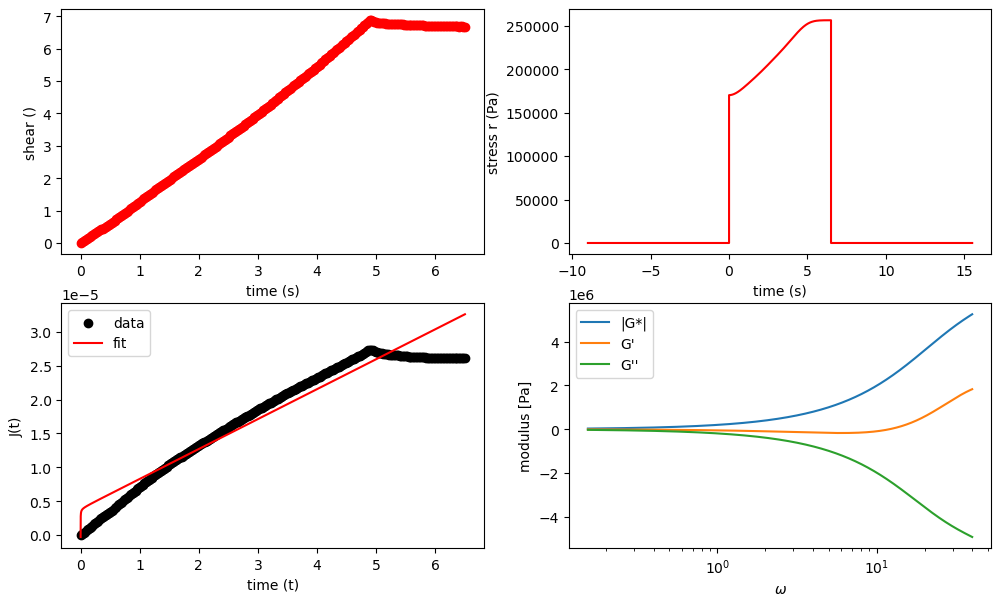

In [86]:
fig, ax  = plt.subplots(2, 2, figsize = (12,7))


ax[0,0].scatter(t,gamma, color = "red")
ax[0,0].set_xlabel("time (s)")
ax[0,0].set_ylabel(r'shear ()')

ax[0,1].plot(np.concatenate((np.arange(-9,1),t,np.arange(6.5,16.5))),np.concatenate((np.repeat(0,10),stress,np.repeat(0,10))), color = "red")
ax[0,1].set_xlabel("time (s)")
ax[0,1].set_ylabel("stress r (Pa)")


ax[1,0].scatter(t,J, label = "data", color = "black")
ax[1,0].plot(xdata,ydata, label = "fit", color = "red")
ax[1,0].legend()

ax[1,0].set_xlabel(r'time (t)')
ax[1,0].set_ylabel("J(t)")

ax[1,1].plot(omega, np.abs(e_data), label = "|G*|")
ax[1,1].plot(omega, np.real(e_data), label = "G'")
ax[1,1].plot(omega, -np.imag(e_data), label = "G''")

ax[1,1].set_xscale("log")
ax[1,1].set_xlabel(r'$\omega$')
ax[1,1].set_ylabel("modulus [Pa]")

ax[1,1].legend()
